# Chapter 2
> Four motivating datasets

- toc: true 
- badges: true
- comments: true
- author: Zeel Patel
- categories: [GP]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from polire.interpolate import Kriging

## Rocket booster dynamics

NASA explored possibility of creating a launcher that can be reused after launching the payload. Simulation was created for this and below case study explores the two experiments performed on emulators and story behind that.

Data has three input variables (mach, alpha and beta) and six output variables. This is taken from the initial experiments containing 3167 simulations.

In [2]:
lgbb1 = pd.read_table('data/lgbb/lgbb_original.txt', sep=' ', skiprows=21)
print('shape of data is',lgbb1.shape)
lgbb1.head(2)

shape of data is (3167, 9)


,mach,alpha,beta,lift,drag,pitch,side,yaw,roll
0,0.2,-5,0.0,-0.09536,0.00060,-0.02869,0.00076,-0.00032,0.00010
1,0.2,-2,0.0,0.05032,0.02859,-0.03162,0.00139,-0.00045,0.00016


Let's see relation between alpha, mach and lift.

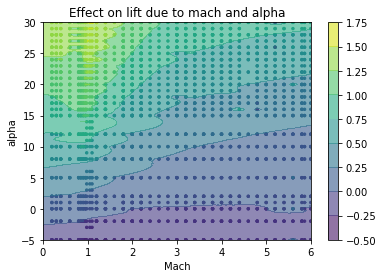

In [3]:
interp = Kriging()
interp.fit(lgbb1[['mach','alpha']].values, lgbb1['lift'].values)
Xi, Yi = np.meshgrid(np.linspace(0,6,200), np.linspace(-5,30,200))
XiYi = np.vstack([Xi.ravel(),Yi.ravel()]).T
zi = interp.predict(XiYi).reshape(200,200)

plt.scatter(lgbb1.mach, lgbb1.alpha,s=6,c=lgbb1.lift);
cntr = plt.contourf(Xi, Yi, zi, alpha=0.6);

plt.colorbar();plt.xlabel('Mach');plt.ylabel('alpha');
plt.title('Effect on lift due to mach and alpha');

Sampling is dense at region where alpha is high and mach ~ 1. This was done to accomodate high variations at that region.

Grid has two drawbacks here i) Despite high number of samples, unique values per input variables are less; ii) Numerical stability.

Let's visualize relation between mach and lift when beta is zero and non-zero (keeping alpha==1).

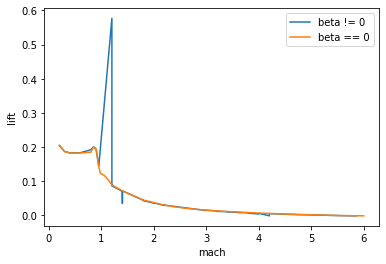

In [4]:
tmp_df = lgbb1.sort_values('mach')
tmp_df = tmp_df[tmp_df['alpha']==1]

fig, ax = plt.subplots()
tmp_df[tmp_df['beta'] != 0].plot(x='mach',y='lift',ax=ax, label='beta != 0',ylabel='lift');
tmp_df[tmp_df['beta'] == 0].plot(x='mach',y='lift',ax=ax, label='beta == 0');

When beta != 0, lift output has problems here and also this plot has low resolution. So, second experiment was carried out to solve following problems.
* an adaptive design without gridding
* better numerics (improvements to Cart3D)
* paired with an ability to back-out a high resolution surface, smoothing out the gaps, based on relatively few total simulations

To generate second version of dataset, active learning with treed gaussian process (TGP) model are used. This time only 780 simulations were done.

In [5]:
lgbb2 = pd.read_table('data/lgbb/lgbb_as.txt',sep=' ', skiprows=32)
lgbb2 = lgbb2.set_index('index').sort_index()

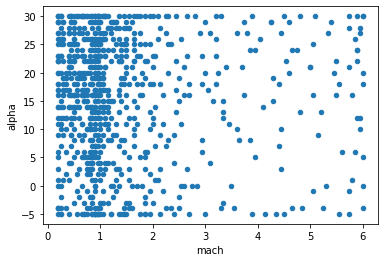

In [6]:
lgbb2.plot(x='mach',y='alpha',kind='scatter');

Values chosen for mach variable has become much finer compared to earlier experiments.

In [7]:
for col in ['mach','alpha','beta']:
    print('lgbb1 unique values for',col,'=',lgbb1[col].unique().shape[0])
    print('lgbb2 unique values for',col,'=',lgbb2[col].unique().shape[0])
    print()

lgbb1 unique values for mach = 37
lgbb2 unique values for mach = 110

lgbb1 unique values for alpha = 33
lgbb2 unique values for alpha = 36

lgbb1 unique values for beta = 6
lgbb2 unique values for beta = 9



Now, plotting the beta==0 and beta != 0 (alpha == 1)figure again.

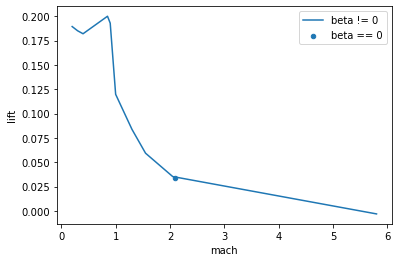

In [8]:
tmp_df = lgbb2.sort_values('mach')
tmp_df = tmp_df[tmp_df['alpha']==1]

fig, ax = plt.subplots()
tmp_df[tmp_df['beta'] != 0].plot(x='mach',y='lift',ax=ax, label='beta != 0',ylabel='lift');
tmp_df[tmp_df['beta'] == 0].plot(x='mach',y='lift',ax=ax, label='beta == 0',kind='scatter');

We see that peak is removed now.

Visualizing interpolated dense surface from TGP results.

In [9]:
import rdata
parsed = rdata.parser.parse_file('data/lgbb/lgbb_fill.RData')
lgbb_fill = rdata.conversion.convert(parsed)['lgbb.fill']

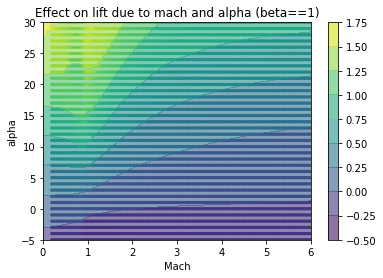

In [10]:
tmp_df = lgbb_fill[lgbb_fill.beta==1]
interp = Kriging()
interp.fit(tmp_df[['mach','alpha']].values, tmp_df['lift'].values)
Xi, Yi = np.meshgrid(np.linspace(0,6,200), np.linspace(-5,30,200))
XiYi = np.vstack([Xi.ravel(),Yi.ravel()]).T
zi = interp.predict(XiYi).reshape(200,200)

plt.scatter(tmp_df.mach, tmp_df.alpha,s=6,c=tmp_df.lift);
cntr = plt.contourf(Xi, Yi, zi, alpha=0.6);

plt.colorbar();plt.xlabel('Mach');plt.ylabel('alpha');
plt.title('Effect on lift due to mach and alpha (beta==1)');

The plot suggests complex relationship near mach==1 and high alpha values.

Checking relationship between mach and lift for all unique values of alpha (beta==1).

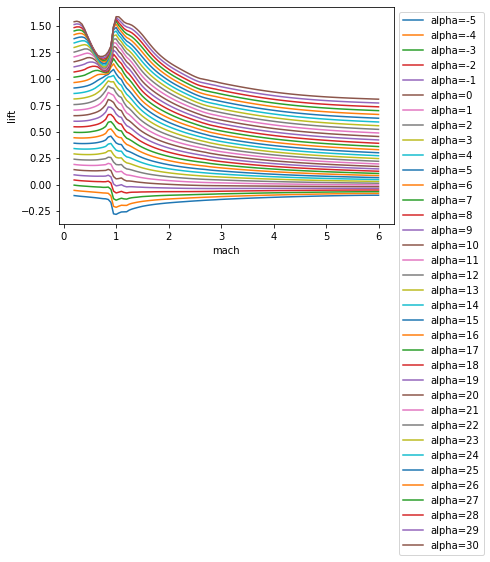

In [12]:
fig, ax = plt.subplots()
for i,val in enumerate(lgbb_fill.alpha.unique()):
    tmp_df = lgbb_fill[lgbb_fill.alpha==val]
    tmp_df = tmp_df[tmp_df.beta==1]
    plt.plot(tmp_df['mach'], tmp_df['lift'], label='alpha='+str(val.round(2)));
plt.legend(bbox_to_anchor=[1,1]);
plt.xlabel('mach');plt.ylabel('lift');

The key of this experiment was to understand dynamics better. Experiments found interesting region automatically with Active Learning techniques. In this case, design was simple to sample more points where uncertainty is high.

## Radiative shock hydrodynamics

We are interested in knowing location of radiative show wave head in xenon tube in this experiment. It contains 9 design variables but observations are too low (20).

In [11]:
crash = pd.read_csv('data/crash/CRASHExpt_clean.csv')
crash['BeThickness'] = 21
print('shape of data is',crash.shape)
crash.head(2)

shape of data is (20, 9)


,LaserEnergy,GasPressure,AspectRatio,NozzleLength,TaperLength,TubeDiameter,Time,ShockLocation,BeThickness
0,3889.6,1.133,1,500,500,575,1.400000e-08,2285.8,21
1,3889.6,1.133,1,500,500,575,1.600000e-08,2499.9,21


In experiment 1 (ce1) laser energy scale factor is used. In 2nd experiment directly effective laser energy is used.

In [12]:
ce1 = pd.read_csv("data/crash/RS12_SLwithUnnormalizedInputs.csv")
ce2 = pd.read_csv("data/crash/RS13Minor_SLwithUnnormalizedInputs.csv")
ce2.ElectronFluxLimiter = 0.06

In [13]:
sfmin = ce2.EffectiveLaserEnergy/5000
sflen = 10
ce2_sf = pd.DataFrame(np.random.rand(sflen*ce2.shape[0], ce2.shape[1]+2)*np.nan)
for i in range(1,sflen+1):
    sfi = sfmin + (1 - sfmin)*(i/sflen)
    ce2_sf.iloc[(i-1)*ce2.shape[0] + np.arange(ce2.shape[0]),:] = \
    np.hstack([ce2.values, sfi.values.reshape(-1,1), (ce2.EffectiveLaserEnergy/sfi).values.reshape(-1,1)])
ce2_sf.columns = ce2.columns.tolist() + ["EnergyScaleFactor", "LaserEnergy"]
ce2_sf.columns

Index(['FileNumber', 'BeThickness', 'EffectiveLaserEnergy', 'GasPressure',
       'AspectRatio', 'NozzleLength', 'TaperLength', 'TubeDiameter', 'Time',
       'ElectronFluxLimiter', 'ShockLocation', 'EnergyScaleFactor',
       'LaserEnergy'],
      dtype='object')

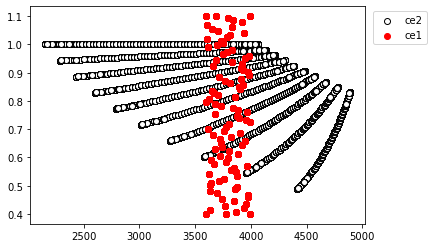

In [25]:
plt.scatter(ce2_sf.LaserEnergy, ce2_sf.EnergyScaleFactor,c='w',edgecolors= "black",label='ce2')
plt.scatter(ce1.LaserEnergy, ce1.EnergyScaleFactor,c='r',label='ce1');
plt.legend(bbox_to_anchor=[1.2,1]);

## Satelite drag

```tpm``` library developed (wrapper over original C library) by author is used to calculate satelite drag. Then a GP surrogate was used to have root mean sqaured percentage error below 1%.

Actual design had too many data points that were beyong GP capability to model. So, range of ```thata``` and ```phi``` was reduced to generate 1000 train and 100 test points using LHS.

In [61]:
names = ['Umag','Ts','Ta','alphan','sigmat','theta','phi','Cd']
train = pd.read_csv("data/lanl/GRACE/CD_GRACE_1000_He.dat",sep=' ',names=names)
test = pd.read_csv("data/lanl/GRACE/CD_GRACE_100_He.dat",sep=' ',names=names)
train.describe()

,Umag,Ts,Ta,alphan,sigmat,theta,phi,Cd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,7513.339621,299.993130,1100.012022,0.500008,0.500006,0.034134,0.000050,3.737018
std,1176.512980,115.524068,519.877619,0.288828,0.288817,0.020290,0.040970,0.828606
min,5501.933000,100.312700,201.223200,0.000882,0.000761,0.000013,-0.069781,1.994381
25%,6502.452500,200.194700,649.939925,0.250170,0.250216,0.016469,-0.036841,3.117479
50%,7505.025000,299.956950,1099.937500,0.500369,0.500341,0.034206,-0.000410,3.654797
75%,8568.225000,399.841525,1549.948250,0.749546,0.749722,0.052085,0.036675,4.269964
max,9497.882000,499.841000,1999.999000,0.999215,0.999790,0.069783,0.069663,6.789995


Visualizing LHS design

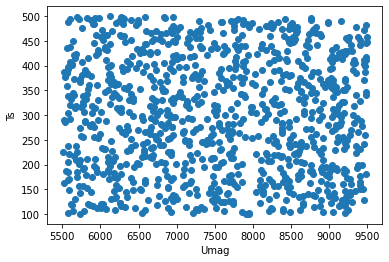

In [64]:
plt.scatter(train.Umag, train.Ts);
plt.xlabel('Umag');plt.ylabel('Ts');

In [68]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import GPy

In [82]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
train_scaled, test_scaled = train.copy(), test.copy()
scaler.fit(pd.concat([train,test]))
train_scaled[train.columns] = scaler.transform(train)
test_scaled[test.columns] = scaler.transform(test)

Fitting GP model

In [83]:
X_train = train_scaled.values[:,:7]
X_test = test_scaled.values[:,:7]
y_train = train.values[:,7:8]
y_test = test.values[:,7:8]

In [88]:
dim = X_train.shape[1]
kernel = GPy.kern.RBF(dim,active_dims=range(dim),ARD=True)
model = GPy.models.GPRegression(X_train, y_train, kernel)
model.optimize()

In [89]:
y_pred = model.predict(X_test)[0]
rmspe = np.sqrt(np.mean(np.square(100*(y_pred-y_test)/y_test)))
rmspe

0.7587825861705741

rmspe is less than 1% as required.

# Homework

## 1: The other five LGBB outputs

In [19]:
lgbb_fill.columns

Index(['mach', 'alpha', 'beta', 'lift', 'drag', 'pitch', 'side', 'yaw',
       'roll'],
      dtype='object')

### drag

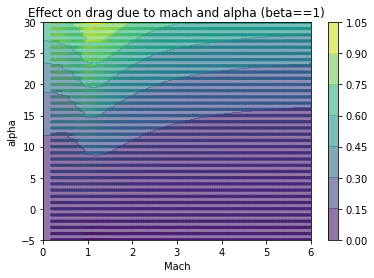

In [27]:
tmp_df = lgbb_fill[lgbb_fill.beta==1]
interp = Kriging()
interp.fit(tmp_df[['mach','alpha']].values, tmp_df['drag'].values)
Xi, Yi = np.meshgrid(np.linspace(0,6,200), np.linspace(-5,30,200))
XiYi = np.vstack([Xi.ravel(),Yi.ravel()]).T
zi = interp.predict(XiYi).reshape(200,200)

plt.scatter(tmp_df.mach, tmp_df.alpha,s=6,c=tmp_df.lift);
cntr = plt.contourf(Xi, Yi, zi, alpha=0.6);

plt.colorbar();plt.xlabel('Mach');plt.ylabel('alpha');
plt.title('Effect on drag due to mach and alpha (beta==1)');

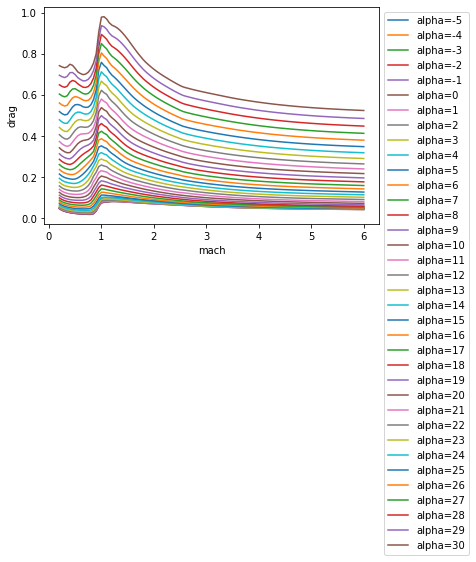

In [13]:
fig, ax = plt.subplots()
for i,val in enumerate(lgbb_fill.alpha.unique()):
    tmp_df = lgbb_fill[lgbb_fill.alpha==val]
    tmp_df = tmp_df[tmp_df.beta==1]
    plt.plot(tmp_df['mach'], tmp_df['drag'], label='alpha='+str(val.round(2)));
plt.legend(bbox_to_anchor=[1,1]);
plt.xlabel('mach');plt.ylabel('drag');

### side beta ==0 and beta == 1

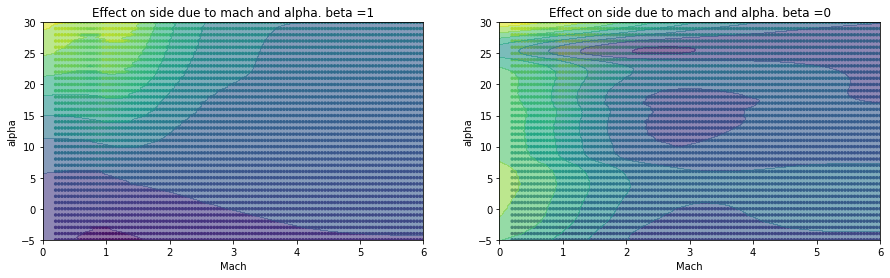

In [14]:
tmp_dfs = [lgbb_fill[lgbb_fill.beta==1], lgbb_fill[lgbb_fill.beta==0]]
beta = ['1','0']
fig, ax = plt.subplots(1,2,figsize=(15,4))
zis = []
for i, tmp_df in enumerate(tmp_dfs):
    interp = Kriging()
    interp.fit(tmp_df[['mach','alpha']].values, tmp_df['side'].values)
    Xi, Yi = np.meshgrid(np.linspace(0,6,200), np.linspace(-5,30,200))
    XiYi = np.vstack([Xi.ravel(),Yi.ravel()]).T
    zi = interp.predict(XiYi).reshape(200,200)
    zis.append(zi)
    
    ax[i].scatter(tmp_df.mach, tmp_df.alpha,s=6,c=tmp_df.lift);
    cntr = ax[i].contourf(Xi, Yi, zi, alpha=0.6);

    ax[i].set_xlabel('Mach');ax[i].set_ylabel('alpha');
    ax[i].set_title('Effect on side due to mach and alpha. beta ='+beta[i]);

Now, checking side for each unique value of beta

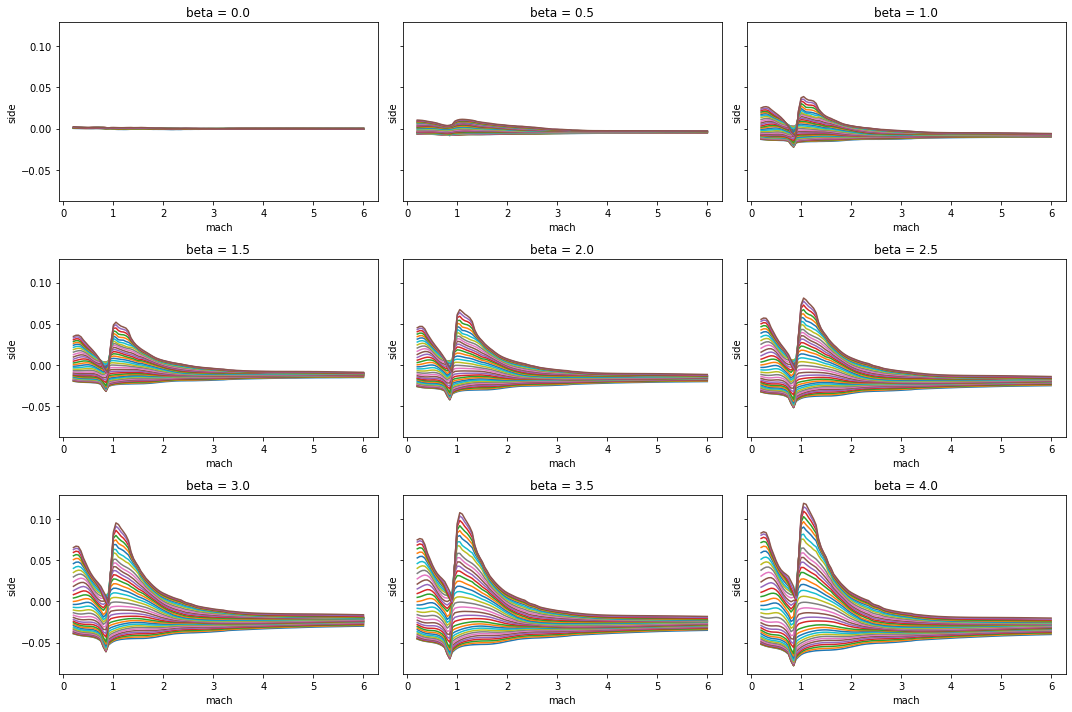

In [43]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['side'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('side');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()

### yaw

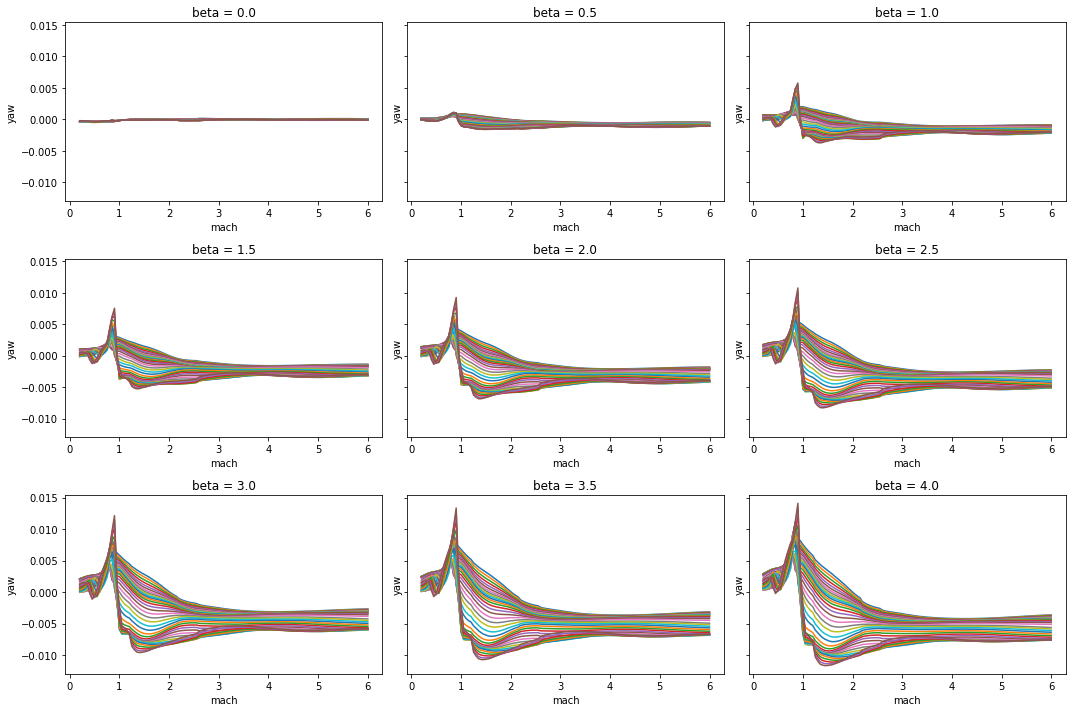

In [44]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['yaw'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('yaw');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()

### roll

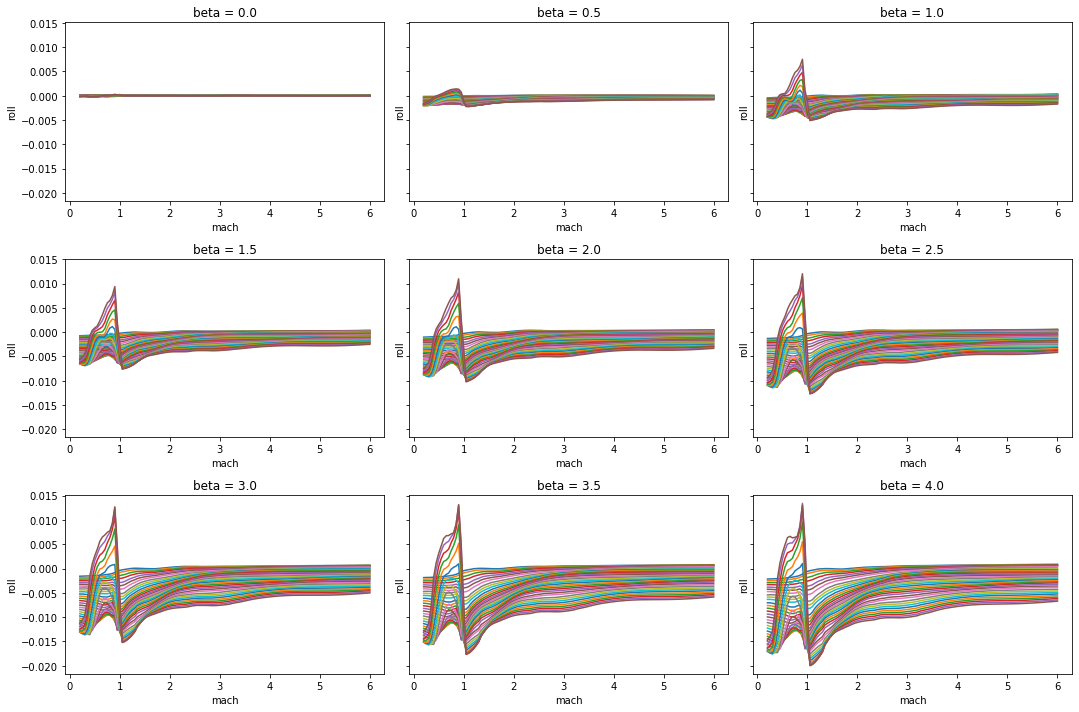

In [45]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['roll'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('roll');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()

### lift

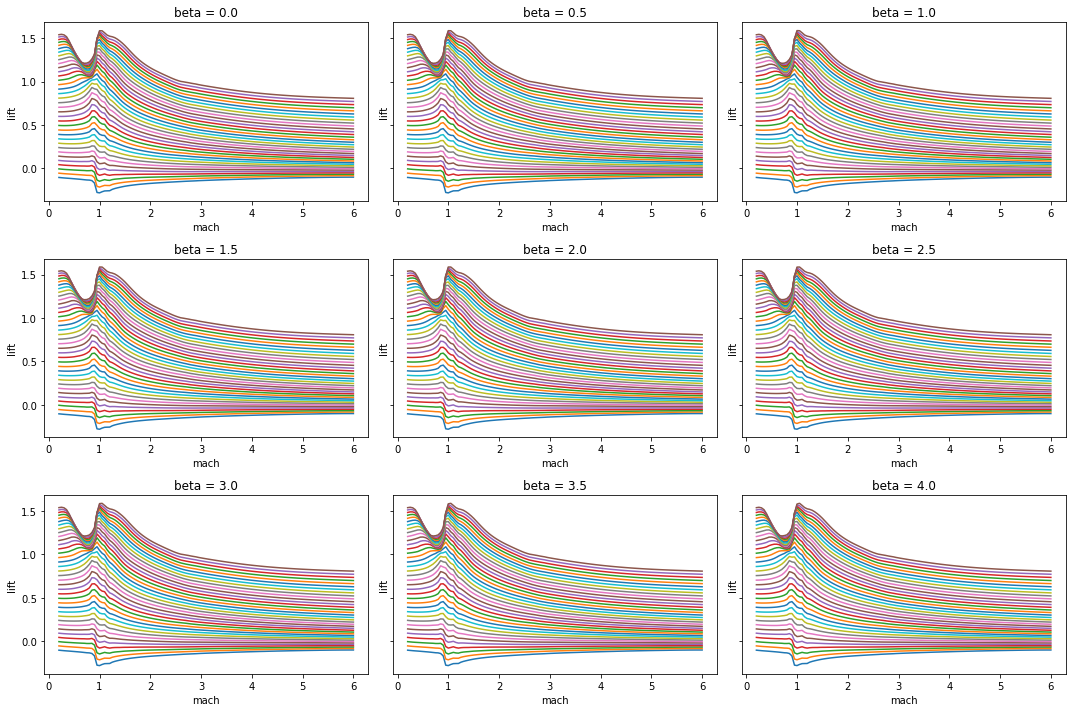

In [46]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['lift'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('lift');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()

### drag

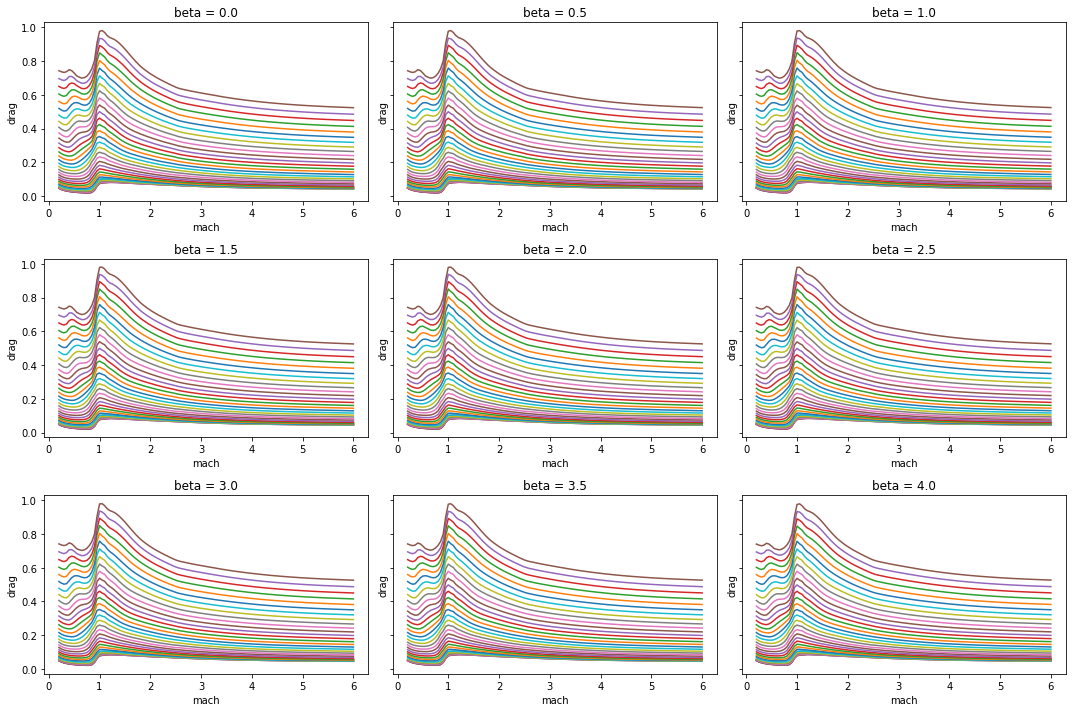

In [48]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['drag'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('drag');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()

### pitch

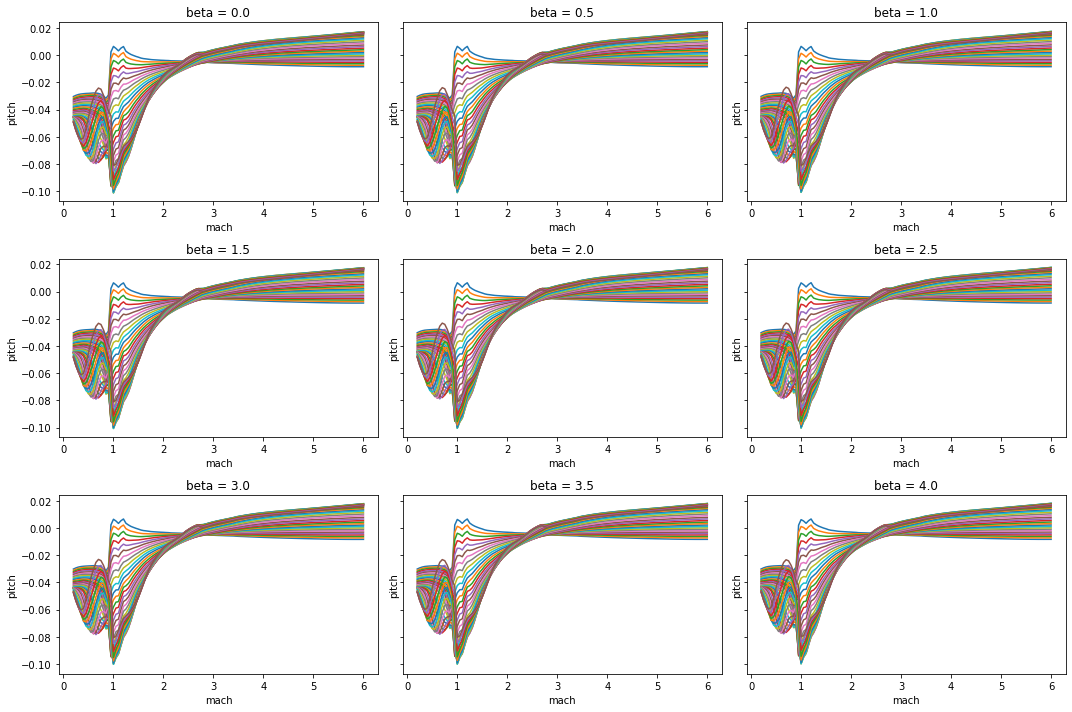

In [49]:
fig, axs = plt.subplots(3,3,figsize=(15,10), sharey=True)
ax = axs.ravel()
for f_i,beta in enumerate(np.arange(0,4.5,0.5)):
    tmp_df = lgbb_fill[lgbb_fill.beta==beta]
    for i,val in enumerate(tmp_df.alpha.unique()):
        tmp_df2 = tmp_df[tmp_df.alpha==val]
        ax[f_i].plot(tmp_df2['mach'], tmp_df2['pitch'], label='alpha='+str(val.round(2)));
#     ax[beta].legend(bbox_to_anchor=[1,1]);
    ax[f_i].set_xlabel('mach');ax[f_i].set_ylabel('pitch');
    ax[f_i].set_title('beta = '+str(beta))
plt.tight_layout()